<a href="https://www.kaggle.com/code/tomvaucourt/progan-synthetic-drusen-generation?scriptVersionId=146585946" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

Hi ! The goal of this notebook is to produce **synthetic OCT scans** of the **DRUSEN** pathology.
It is achieved by training the original [ProGan](https://arxiv.org/abs/1710.10196) as implemented by [Aladdin Persson](https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/ProGAN). 

I kept most of Aladdin Persson's comments about the model and its functioning. My contributions consist in the adaptation of the code for easy training and generation using Kaggle or Colab GPUs. 

The model was trained on the DRUSEN part of the dataset for **40 to 50 epochs** from **image size 4 to 256**. 
As training is quite long, ***critic and generator weights are provided*** in the progan-oct-drusen_weights dataset. 
You can use the weights to train the model further or generate synthetic data.

If you want to **train the mode further**, you can visualize its progress using tensorboard which I set up below (be aware that tensorboard doesn't work with all browsers on kaggle).
If you want to **generate synthetic DRUSEN images**, you'll be able to build a 2 fps video of all generated images.

Select what you want to do below. If both are true, the model will only train.

In [1]:
TRAIN_MODEL = False
GENERATE_DATA = True

# Imports

In [2]:
import random
import numpy as np
import os
from collections import OrderedDict
import shutil
import zipfile
import cv2
from PIL import Image
import glob
import matplotlib.pyplot as plt
from math import log2
from scipy.stats import truncnorm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image

from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Config

Change ngpu depending on the **number of GPUs** you're using

In [3]:
START_TRAIN_AT_IMG_SIZE = 512
CHECKPOINT_GEN = "/kaggle/input/progan-oct-drusen-weights/generator_DRUSEN_v11.pth"
CHECKPOINT_CRITIC = "/kaggle/input/progan-oct-drusen-weights/critic_DRUSEN_v11.pth"
CHECKPOINT_GEN_SAVE = "generator_DRUSEN_v12.pth"
CHECKPOINT_CRITIC_SAVE = "critic_DRUSEN_v12.pth"
ngpu = 2 #NUMBER OF GPU USED (can be 0 for CPU only)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
SAVE_MODEL = False
LOAD_MODEL = True
LEARNING_RATE = 1e-3
BATCH_SIZES = [32, 32, 32, 16, 16, 16, 16, 8, 4]
CHANNELS_IMG = 3
Z_DIM = 256  # should be 512 in original paper
IN_CHANNELS = 256  # should be 512 in original paper
CRITIC_ITERATIONS = 1
LAMBDA_GP = 10
PROGRESSIVE_EPOCHS = [30] * len(BATCH_SIZES)
FIXED_NOISE = torch.randn(8, Z_DIM, 1, 1).to(device)
NUM_WORKERS = 2

# Set up dataset

I set up the data this way to be able to use the pytorch **ImageFolder** dataloader easily. The operation may take a minute or two.

In [4]:
if TRAIN_MODEL:
    shutil.copytree('/kaggle/input/kermany2018/OCT2017 /train/DRUSEN/','/kaggle/working/images/OCT2017 /train/DRUSEN/')

# Utils

In [5]:
# Print losses occasionally and print to tensorboard
def plot_to_tensorboard(
    writer, loss_critic, loss_gen, real, fake, tensorboard_step
):
    writer.add_scalar("Loss Critic", loss_critic, global_step=tensorboard_step)
    writer.add_scalar("Loss Generator", loss_gen, global_step=tensorboard_step)

    with torch.no_grad():
        # take out (up to) 8 examples to plot
        img_grid_real = torchvision.utils.make_grid(real[:8], normalize=True, nrow = 4)
        img_grid_fake = torchvision.utils.make_grid(fake[:8], normalize=True, nrow = 4)
        writer.add_image("Real", img_grid_real, global_step=tensorboard_step)
        writer.add_image("Fixed fake", img_grid_fake, global_step=tensorboard_step)


def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print(f"=> Saving checkpoint {filename}",)
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename) #save locally
    
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print(f"=> Loading checkpoint {checkpoint_file}")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    if (device.type == 'cuda') and (ngpu > 1):
        checkpoint = convert_dict_parallel(checkpoint)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

        
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def generate_examples(steps, truncation=0.7, n=100, generate_data = GENERATE_DATA):
    """
    Tried using truncation trick here but not sure it actually helped anything, you can
    remove it if you like and just sample from torch.randn
    """
    if generate_data:
        gen = Generator(ngpu, Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG).to(device)
        opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
        scaler_gen = torch.cuda.amp.GradScaler()
        
        if (device.type == 'cuda') and (ngpu > 1):
            gen = nn.DataParallel(gen, list(range(ngpu)))

        # for tensorboard plotting
        writer = SummaryWriter("logs")

        if LOAD_MODEL:
            load_checkpoint(
                CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE,
            )
        gen.eval()
        alpha = 1.0
        for i in tqdm(range(n)):
            with torch.no_grad():
                noise = torch.tensor(truncnorm.rvs(-truncation, truncation, size=(1, Z_DIM, 1, 1)), device=device, dtype=torch.float32)
                img = gen(noise, alpha, steps)
                save_image(img*0.5+0.5, f"saved_examples/img_{i}.png")
        gen.train()
        
def convert_dict_parallel(dict_checkpoint):
    state_dict = dict_checkpoint
    # create new OrderedDict that does not contain `module.`
    new_state_dict_sd = OrderedDict()
    for k, v in state_dict['state_dict'].items():
        name = 'module.'+k # remove `module.`
        new_state_dict_sd[name] = v
    new_state_dict = OrderedDict([('state_dict',new_state_dict_sd), ('optimizer',state_dict['optimizer'])])
    return new_state_dict    

In [6]:
seed_everything()

# Model

## Layers

In [7]:
class WSConv2d(nn.Module):
    """
    Weight scaled Conv2d (Equalized Learning Rate)
    Note that input is multiplied rather than changing weights
    this will have the same result.

    Inspired and looked at:
    https://github.com/nvnbny/progressive_growing_of_gans/blob/master/modelUtils.py
    """

    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2,
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)


class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x

## Generator

In [8]:
"""
Implementation of ProGAN generator and discriminator with the key
attributions from the paper. We have tried to make the implementation
compact but a goal is also to keep it readable and understandable.
Specifically the key points implemented are:

1) Progressive growing (of model and layers)
2) Minibatch std on Discriminator
3) Normalization with PixelNorm
4) Equalized Learning Rate (here I cheated and only did it on Conv layers)

Factors is used in Discrmininator and Generator for how much
the channels should be multiplied and expanded for each layer,
so specifically the first 5 layers the channels stay the same,
whereas when we increase the img_size (towards the later layers)
we decrease the number of chanels by 1/2, 1/4, etc.
"""

factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]


class Generator(nn.Module):
    def __init__(self, ngpu, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        # initial takes 1x1 -> 4x4
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )

        for i in range(
            len(factors) - 1
        ):  # -1 to prevent index error because of factors[i+1]
            conv_in_c = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, x, alpha, steps):
        out = self.initial(x)

        if steps == 0:
            return self.initial_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)

## Critic or discriminator

In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu,z_dim, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

## Model test

In [10]:
#Model test

Z_DIM = 100
IN_CHANNELS = 256
gen = Generator(ngpu, Z_DIM, IN_CHANNELS, img_channels=3)
critic = Discriminator(ngpu, Z_DIM, IN_CHANNELS, img_channels=3)

for img_size in [4, 8, 16, 32, 64, 128, 256, 512, 1024]:
    num_steps = int(log2(img_size / 4))
    x = torch.randn((1, Z_DIM, 1, 1))
    z = gen(x, 0.5, steps=num_steps)
    assert z.shape == (1, 3, img_size, img_size)
    out = critic(z, alpha=0.5, steps=num_steps)
    assert out.shape == (1, 1)
    print(f"Success! At img size: {img_size}")

Z_DIM = 256 #Don't forget to reset Z_DIM after testing

Success! At img size: 4
Success! At img size: 8
Success! At img size: 16
Success! At img size: 32
Success! At img size: 64
Success! At img size: 128
Success! At img size: 256
Success! At img size: 512
Success! At img size: 1024


# Load and train

## Loader

In [11]:
torch.backends.cudnn.benchmarks = True

def get_loader(image_size):
    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.CenterCrop((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(
                [0.5 for _ in range(CHANNELS_IMG)],
                [0.5 for _ in range(CHANNELS_IMG)],
            ),
        ]
    )
    dataroot = '/kaggle/working/images/OCT2017 /train/DRUSEN/'
    batch_size = BATCH_SIZES[int(log2(image_size / 4))]
    dataset = datasets.ImageFolder(root=dataroot, transform=transform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    return loader, dataset

## Training loop

In [12]:
""" Training of ProGAN using WGAN-GP loss"""

def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen,
    tensorboard_step,
    writer,
    scaler_gen,
    scaler_critic,
):
    loop = tqdm(loader, leave=True)
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)] <-> min -E[critic(real)] + E[critic(fake)]
        # which is equivalent to minimizing the negative of the expression
        noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)

        with torch.cuda.amp.autocast():
            fake = gen(noise, alpha, step)
            critic_real = critic(real, alpha, step)
            critic_fake = critic(fake.detach(), alpha, step)
            gp = gradient_penalty(critic, real, fake, alpha, step, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake))
                + LAMBDA_GP * gp
                + (0.001 * torch.mean(critic_real ** 2))
            )

        opt_critic.zero_grad()
        scaler_critic.scale(loss_critic).backward()
        scaler_critic.step(opt_critic)
        scaler_critic.update()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        with torch.cuda.amp.autocast():
            gen_fake = critic(fake, alpha, step)
            loss_gen = -torch.mean(gen_fake)

        opt_gen.zero_grad()
        scaler_gen.scale(loss_gen).backward()
        scaler_gen.step(opt_gen)
        scaler_gen.update()

        # Update alpha and ensure less than 1

        alpha += cur_batch_size / (
            (PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
        alpha = min(alpha, 1)


        if batch_idx % 10 == 0: #FIXED NOISE CALCULATION FREQUENCY
            with torch.no_grad():
                fixed_fakes = gen(FIXED_NOISE, alpha, step) * 0.5 + 0.5
            plot_to_tensorboard(
                writer,
                loss_critic.item(),
                loss_gen.item(),
                real.detach(),
                fixed_fakes.detach(),
                tensorboard_step,
            )
            tensorboard_step += 1

        loop.set_postfix(
            gp=gp.item(),
            loss_critic=loss_critic.item(),
        )

    return tensorboard_step, alpha

# 📙 Tensorboard

In [13]:
%load_ext tensorboard
#%reload_ext tensorboard

In [14]:
%tensorboard --logdir logs

# Main

In [15]:
def main():
    # initialize gen and disc, note: discriminator should be called critic,
    # according to WGAN paper (since it no longer outputs between [0, 1])
    # but really who cares..
    gen = Generator(ngpu, Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG).to(device)
    critic = Discriminator(ngpu, Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG).to(device)


    if (device.type == 'cuda') and (ngpu > 1):
        gen = nn.DataParallel(gen, list(range(ngpu)))
        critic = nn.DataParallel(critic, list(range(ngpu)))

    # initialize optimizers and scalers for FP16 training
    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
    opt_critic = optim.Adam(
        critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99)
    )
    scaler_critic = torch.cuda.amp.GradScaler()
    scaler_gen = torch.cuda.amp.GradScaler()

    # for tensorboard plotting
    writer = SummaryWriter("logs")

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC, critic, opt_critic, LEARNING_RATE,
        )

    gen.train()
    critic.train()

    tensorboard_step = 0
    # start at step that corresponds to img size that we set in config
    step = int(log2(START_TRAIN_AT_IMG_SIZE / 4))
    for num_epochs in PROGRESSIVE_EPOCHS[step:]:
        alpha = 1e-5  # start with very low alpha
        loader, dataset = get_loader(4 * 2 ** step)  # 4->0, 8->1, 16->2, 32->3, 64 -> 4
        print(f"Current image size: {4 * 2 ** step}")

        for epoch in range(num_epochs):
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            tensorboard_step, alpha = train_fn(
                critic,
                gen,
                loader,
                dataset,
                step,
                alpha,
                opt_critic,
                opt_gen,
                tensorboard_step,
                writer,
                scaler_gen,
                scaler_critic,
            )

            if SAVE_MODEL:
                save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN_SAVE)
                save_checkpoint(critic, opt_critic, filename=CHECKPOINT_CRITIC_SAVE)

        step += 1  # progress to the next img size

In [16]:
if TRAIN_MODEL:
    main()

# ✴ Generate examples

In [17]:
!mkdir '/kaggle/working/saved_examples/'

In [18]:
generate_examples(6, truncation=0.7, n=500, generate_data = GENERATE_DATA)

=> Loading checkpoint /kaggle/input/progan-oct-drusen-weights/generator_DRUSEN_v11.pth


100%|██████████| 500/500 [00:27<00:00, 18.28it/s]


You can choose the size of the images you want to generate. Be aware that the model wasn't trained beyond 256 pixels.

In [19]:
int(log2(256 / 4))

6

### Save as a video at 2 fps

In [20]:
frameSize = (256, 256)

out = cv2.VideoWriter('DRUSEN_samples.avi',cv2.VideoWriter_fourcc(*'DIVX'), 2, frameSize)

for filename in glob.glob('/kaggle/working/saved_examples/*.png'):
    img = cv2.imread(filename)
    out.write(img)

out.release()

### Show a few examples

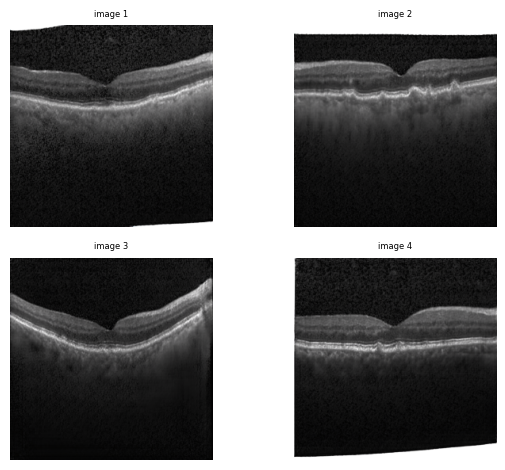

In [21]:
folder_dir = "/kaggle/working/saved_examples"
nb_examples = len(os.listdir(folder_dir))
examples = os.listdir(folder_dir)
             
for i, image in enumerate(examples[:4]):
    ax = plt.subplot(2, 2, i + 1)
    img = np.asarray(Image.open(f'/kaggle/working/saved_examples/{image}'))
    plt.title(f'image {i+1}', fontsize=6)
    plt.axis("off")
    plt.imshow(img)
plt.tight_layout()

**Thank you for reading this notebook !** Please feel free to comment to tell me what you think and what I could have done differently.

[Github of the project](https://github.com/T0mSIlver/OCT_GANs)

This project is not over. I'll be working on the application of GANs to OCT and DFE images for the next few months, feel free to [contact me](mailto:tom.vaucourt@centrale.centralelille.fr) if you're interested in the topic too.

# MIT Disclaimer

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.